# Training Data




## This notebook assumes you have the DC2 data downloaded  

You will have to change directorty paths

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
import deepdisc
import detectron2
print(deepdisc.__file__)
print(detectron2.__file__)

/home/g4merz/deepdisc/src/deepdisc/__init__.py
/home/g4merz/detectron2/detectron2/__init__.py


In [2]:
# Standard imports
import sys, os
import numpy as np
import time
import glob

import scarlet
import sep
import cv2
import json


import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.stats import sigma_clipped_stats

from astropy.coordinates import SkyCoord

from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

# Astrodet imports
import deepdisc.preprocessing.detection as detection
import deepdisc.preprocessing.process as process


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
#matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')
from skimage.util.shape import view_as_blocks
from matplotlib import colors

import pandas as pd
import math
from astropy.table import Table

In [3]:
import galsim
import btk
from astropy.stats import gaussian_fwhm_to_sigma
from galcheat.utilities import mag2counts, mean_sky_level
import astropy.units as u


### Using an input catalog

The cells below assume you have an input catalog `all_tracts_cat.csv` corresponding to the tracts and patches you've downloaded.  We can run the code without one, but it is necessary for truth-matching any quantities

In [4]:
def load_cutout_data(tile, cutout_id, wcs_header=None):
    """Load essential truth catalog data for a specific cutout"""
    base_filename = f'c{cutout_id}_{tile}'
    paths = {
        'lsst_img': f'{lsst_dir}dc2_{tile}/full_{base_filename}.npy',
        'truth_cat': f'{lsst_dir}dc2_{tile}/truth_{base_filename}.json',
        'det_cat': f'{lsst_dir}dc2_{tile}/det_{base_filename}.json',
        'matched_det': f'{lsst_dir}dc2_{tile}/matched_{base_filename}.json'
    }

    if not os.path.exists(paths['lsst_img']):
        # we can handle this in the main loop by creating empty dictionaries
        print(f"Warning: Image file for cutout {cutout_id} from tile {tile} does not exist! Skipping.")
        return None

    try:
        lsst_img = np.load(paths['lsst_img'])
        height, width = lsst_img.shape[1], lsst_img.shape[2]
        #estimate sig-clipped background noise
        noise = np.array([sigma_clipped_stats(img)[-1] for img in lsst_img])
        del lsst_img
        # load truth cat if it exists, otherwise create empty dfs
        truth_cat = pd.read_json(paths['truth_cat'], orient='records') if os.path.exists(paths['truth_cat']) else pd.DataFrame()
        return {
            'tile': tile,
            'cutout_id': cutout_id,
            'truth_cat': truth_cat,
            'width': width,
            'height': height,
            'wcs': wcs_header,
            'paths': paths,
            'noise': noise
        }
    except Exception as e:
        print(f"Error loading cutout {cutout_id} from tile {tile}: {e}")
        return None

In [5]:
def process_object(obj_entry, survey, se_kernel, obj_idx, tile, cutout_id, noise, snr_lvl=5):
    """
    Processes a single object from the truth catalog to generate an annotation or a rejection log.
    """
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    segs = []

    # simulate the object and create segmentation masks for each band
    for i,filt in enumerate(filters):
        try:
            # isolated image of object
            im_conv, psf = make_im(obj_entry, survey, filt, noise[i], nx=128, ny=128, get_gso=True)
            #convolve by the psf and threshold with noise multiplied by psf area (Bosch 2018)
            im_conv2 = galsim.Convolve(im_conv, psf)
            image = galsim.Image(128, 128, scale=survey.pixel_scale.to_value("arcsec"))
            im2 = im_conv2.drawImage(image, scale=survey.pixel_scale.to_value("arcsec"), method='no_pixel')
            #PSF effective area
            psfim = psf.drawImage(nx=64,ny=64)
            psf_fac = np.sum(psfim.array**2)
            imd = np.expand_dims(np.expand_dims(im2.array, 0), 0)
            #sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
            #noise from the cutout image
            var = noise[i]**2
            # segmentation mask using the fixed SNR threshold
            maskf = btk.metrics.utils.get_segmentation(imd, var * psf_fac, sigma_noise=snr_lvl)[0][0]
            # dilate the mask by the psf size
            maskf = cv2.morphologyEx(maskf, cv2.MORPH_DILATE, se_kernel)   
            segs.append(maskf)
        except Exception as e:
            # assume no Galsim failures.
            # For now, we create an empty mask to trigger rejection.
            print(f"Galsim failed for {obj_idx} in {filt}! Below is the error:\n {e}")
            segs.append(np.zeros((128, 128), dtype=bool))

    # add masks in separate bands
    combined_mask = np.clip(np.sum(segs,axis=0), a_min=0, a_max=1)
    obj_id = int(obj_entry['id']) if obj_entry['truth_type'] == 2 else int(obj_entry['cosmodc2_id'])
    
    # now when an obj is rejected, save its mask and store the path
    def handle_rejection(reason):
        mask_dir = os.path.join(rejected_mask_dir, tile, f"c{cutout_id}")
        os.makedirs(mask_dir, exist_ok=True)
        mask_path = os.path.join(mask_dir, f"mask_{obj_idx}.npy")
        np.save(mask_path, combined_mask)
        rejected_obj = {
            'obj_id': obj_id,
            'obj_truth_idx': obj_idx,
            'category_id': 1 if obj_entry['truth_type'] == 2 else 0,
            'ra': obj_entry['ra'],
            'dec': obj_entry['dec'],
            'redshift': obj_entry['redshift'],
            'size_true': obj_entry['size_true'],
            'ellipticity_1_true': obj_entry['ellipticity_1_true'],
            'ellipticity_2_true': obj_entry['ellipticity_2_true'],
            'reason': reason,
            'mask_path': mask_path
        }
        for filt in filters:
            rejected_obj[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
            rejected_obj[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
        return 'rejected', rejected_obj
    
    if np.sum(combined_mask) == 0:
        return handle_rejection('empty_mask')

    if np.sum(combined_mask) < 12:
        return handle_rejection('small_mask_12px')

    bbox_coords = get_bbox(combined_mask)
    if bbox_coords is None:
        return handle_rejection('invalid_bbox') # Should be caught by empty mask, but just in case
    
    y0, y1, x0, x1 = bbox_coords
    w, h = x1 - x0, y1 - y0
    
    # bbox relative to full cutout coordinates
    cutout_x, cutout_y = int(obj_entry['cutout_x']), int(obj_entry['cutout_y'])
    bbox = [cutout_x - w/2, cutout_y - h/2, w, h]

    # contours for segmentation
    contours, _ = cv2.findContours((combined_mask).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        contour = contour.flatten()
        if len(contour) > 4: # Must have at least 3 points
            # Adjust contour coordinates to be relative to the full cutout
            contour[::2] += int(np.rint(cutout_x)) - (x0 + w//2)
            contour[1::2] += int(np.rint(cutout_y)) - (y0 + h//2)
            segmentation.append(contour.tolist())

    if len(segmentation) == 0:
        return handle_rejection('invalid_contours')

    # successful ann
    obj_md = {
        'obj_id': obj_id,
        'obj_truth_idx': obj_idx,     
        'category_id': 1 if obj_entry['truth_type'] == 2 else 0, # 2 is star, 1 is galaxy truth_type
        'bbox': bbox,
        'bbox_mode': 1, # BoxMode.XYWH_ABS
        'area': w * h,
        'segmentation': segmentation,
        'ra': obj_entry['ra'],
        'dec': obj_entry['dec'],
        'redshift': obj_entry['redshift'],
        'size_true': obj_entry['size_true'],
        'ellipticity_1_true': obj_entry['ellipticity_1_true'],
        'ellipticity_2_true': obj_entry['ellipticity_2_true']  
    }
    for filt in filters:
        obj_md[f'mag_{filt}'] = obj_entry[f'mag_{filt}'] # AB mag values
        obj_md[f'flux_{filt}'] = obj_entry[f'flux_{filt}'] # flux values (nJy)
        
    return 'success', obj_md

def process_cutout(cutout_data, snr_lvl=5):
    """Generates annotation dicts for all objects in a given cutout."""
    # cutout file does not exist but we still need an empty entry
    if cutout_data is None:
        return {}, {}

    truth_cat = cutout_data['truth_cat']
    
    base_dict = {
        "file_name": cutout_data['paths']['lsst_img'],
        "image_id": cutout_data['cutout_id'],
        "height": cutout_data['height'],
        "width": cutout_data['width'],
        "tile": cutout_data['tile'],
        "det_cat_path": cutout_data['paths']['det_cat'],
        "truth_cat_path": cutout_data['paths']['truth_cat'],
        "matched_det_path": cutout_data['paths']['matched_det'],
        "wcs": cutout_data['wcs']
    }

    if truth_cat.empty:
        # empty dicts 
        print(f"Skipping cutout {cutout_data['cutout_id']} with empty truth catalog.")
        success_dict = {**base_dict, "annotations": []}
        rejected_dict = {**base_dict, "rejected_objs": []}
        return success_dict, rejected_dict

    survey = btk.survey.get_surveys("LSST")
    # structuring element for mask dilation
    # The psf variations are small between bands, so just using i-band is ok
    fwhm = survey.get_filter('i').psf.calculateFWHM()
    sig = gaussian_fwhm_to_sigma * fwhm / survey.pixel_scale.to_value("arcsec")
    se_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (int(2 * sig), int(2 * sig)))

    dcut = dcut_reformat(truth_cat)
    
    annotations = []
    rejected_objs = []
    for idx, obj in dcut.iterrows():
        status, result_dict = process_object(obj, survey, se_kernel, idx, 
                                             cutout_data['tile'], 
                                             cutout_data['cutout_id'], 
                                             cutout_data['noise'],snr_lvl)
        if status == 'success':
            annotations.append(result_dict)
        else:
            rejected_objs.append(result_dict)
    
    success_dict = {**base_dict, "annotations": annotations}
    rejected_dict = {**base_dict, "rejected_objs": rejected_objs}
    
    return success_dict, rejected_dict

In [6]:
def e1e2_to_ephi(e1,e2):
    pa = np.arctan(e2/e1)
    return pa

def dcut_reformat(cat):
    L0 = 3.0128e28
    for band in ['u', 'g', 'r', 'i', 'z', 'y']:
        cat[f'{band}_ab'] = cat[f'mag_true_{band}']
        total_flux = L0 * 10**(-0.4*cat[f'mag_true_{band}'])
        bulge_to_total_ratio = cat[f'bulge_to_total_ratio_{band}']

        cat[f'fluxnorm_bulge_{band}'] = total_flux * bulge_to_total_ratio
        cat[f'fluxnorm_disk_{band}'] = total_flux * (1-bulge_to_total_ratio)
        cat[f'fluxnorm_agn_{band}'] = np.zeros(total_flux.shape)

    cat['a_b'] = cat['size_bulge_true']
    cat['b_b'] = cat['size_minor_bulge_true']

    cat['a_d'] = cat['size_disk_true']
    cat['b_d'] = cat['size_minor_disk_true']
    # pos angle
    cat['pa_bulge'] = e1e2_to_ephi(cat['ellipticity_1_bulge_true'],cat['ellipticity_2_bulge_true']) * 180.0/np.pi

    cat['pa_disk'] = e1e2_to_ephi(cat['ellipticity_1_disk_true'],cat['ellipticity_2_disk_true']) * 180.0/np.pi
    
    cat['pa_tot'] = e1e2_to_ephi(cat['ellipticity_1_true'],cat['ellipticity_2_true']) * 180.0/np.pi

    cat['g1'] = cat['shear_1']
    cat['g2'] = cat['shear_2']
    
    return cat

def get_star_gsparams(mag, flux, noise):
    """
    Get appropriate gsparams given flux and noise

    Parameters
    ----------
    mag: float
        mag of star
    flux: float
        flux of star
    noise: float
        noise of image

    Returns
    --------
    GSParams, isbright where isbright is true for stars with mag less than 18
    """
    do_thresh = do_acc = False
    if mag < 18:
        do_thresh = True
    if mag < 15:
        do_acc = True

    if do_thresh or do_acc:
        isbright = True

        kw = {}
        if do_thresh:

            # this is designed to quantize the folding_threshold values,
            # so that there are fewer objects in the GalSim C++ cache.
            # With continuous values of folding_threshold, there would be
            # a moderately largish overhead for each object.

            folding_threshold = noise/flux
            folding_threshold = np.exp(
                np.floor(np.log(folding_threshold))
            )
            kw['folding_threshold'] = min(folding_threshold, 0.005)

        if do_acc:
            kw['kvalue_accuracy'] = 1.0e-8
            kw['maxk_threshold'] = 1.0e-5

        gsparams = galsim.GSParams(**kw)
    else:
        gsparams = None
        isbright = False

    return gsparams, isbright


def make_star(entry, survey, filt, noise):
    """
    Parameters
    ----------
    survey: WLDeblendSurvey or BasicSurvey
        The survey object
    band: string
        Band string, e.g. 'r'
    i: int
        Index of object
    noise: float
        The noise level, needed for setting gsparams

    Returns
    -------
    galsim.GSObject
    """    
    #https://pipelines.lsst.io/v/DM-22499/cpp-api/file/_photo_calib_8h.html
#     mag = -2.5*np.log10(entry[f'flux_{filt.name}']*1e-9/(1e23*10**(48.6/-2.5)))
    mag = entry[f'mag_{filt.name}']
    #flux = mag2counts(mag,survey,filt).to_value("electron")
    delta_m = mag - 27
    flux = 10 ** (-delta_m / 2.5)
#     flux = entry[f'flux_{filt.name}']
    #noise = mean_sky_level(survey, filt).to_value('electron') # gain = 1
    gsparams, isbright = get_star_gsparams(mag, flux, noise)
    star = galsim.Gaussian(
        fwhm=1.0e-4,
        flux=flux,
        gsparams=gsparams,
    )
    return star, gsparams, flux

def make_galaxy(entry, survey, filt, no_disk= False, no_bulge = False, no_agn = True):
    components = []
    #total_flux = mag2counts(entry[filt.name + "_ab"], survey, filt).to_value("electron")
    delta_m = entry[filt.name + "_ab"] - 27
    total_flux = 10 ** (-delta_m / 2.5)
    # Calculate the flux of each component in detected electrons.
    total_fluxnorm = entry["fluxnorm_disk_"+filt.name] + entry["fluxnorm_bulge_"+filt.name] + entry["fluxnorm_agn_"+filt.name]
    disk_flux = 0.0 if no_disk else entry["fluxnorm_disk_"+filt.name] / total_fluxnorm * total_flux
    bulge_flux = 0.0 if no_bulge else entry["fluxnorm_bulge_"+filt.name] / total_fluxnorm * total_flux
    agn_flux = 0.0 if no_agn else entry["fluxnorm_agn_"+filt.name] / total_fluxnorm * total_flux

    if disk_flux + bulge_flux + agn_flux == 0:
        raise SourceNotVisible

    if disk_flux > 0:
        a_d, b_d = entry["a_d"], entry["b_d"]
        disk_hlr_arcsecs=entry['size_disk_true']
        
        
        disk_q = entry['size_minor_disk_true']/entry['size_disk_true']
        pa = np.pi*entry['position_angle_true_dc2']/180
        
        epsilon_disk = (1 - disk_q) / (1 + disk_q)
        
        e1_disk = epsilon_disk * np.cos(2 * pa)
        e2_disk = epsilon_disk * np.sin(2 * pa)

        disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
            e1=-e1_disk, e2=e2_disk
        )
        
        components.append(disk)
        
        
    if bulge_flux > 0:
        a_b, b_b = entry["a_b"], entry["b_b"]
        bulge_hlr_arcsecs = np.sqrt(a_b * b_b)

        bulge_q = entry['size_minor_bulge_true']/entry['size_bulge_true']

        pa = np.pi*entry['position_angle_true_dc2']/180

        
        epsilon_bulge = (1 - bulge_q) / (1 + bulge_q)
        
        e1_bulge = epsilon_bulge * np.cos(2 * pa)
        e2_bulge = epsilon_bulge * np.sin(2 * pa)
        
        bulge = galsim.DeVaucouleurs(flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs).shear(
           e1=-e1_bulge, e2=e2_bulge
        )
        components.append(bulge)

    if agn_flux > 0:
        agn = galsim.Gaussian(flux=agn_flux, sigma=1e-8)
        components.append(agn)

    profile = galsim.Add(components)
    return profile

def make_im(entry, survey, filt, noise, nx=128, ny=128, get_gso=False):
    psf = survey.get_filter(filt).psf
    #sky_level = mean_sky_level(survey, filt).to_value('electron') # gain = 1
    obj_type = entry['truth_type'] # 1 for galaxies, 2 for stars
    im = None
    if obj_type == 1:
        gal = make_galaxy(entry, survey, survey.get_filter(filt))
        gal = gal.shear(g1=entry["g1"], g2=entry["g2"])
        conv_gal = galsim.Convolve(gal, psf)
#         im = conv_gal.drawImage(
#             nx=nx,
#             ny=ny,
#             scale=survey.pixel_scale.to_value("arcsec")
#         )
        if get_gso:
            return conv_gal, psf
    else:
        star, gsparams, flux = make_star(entry, survey, survey.get_filter(filt),noise)
        max_n_photons = 10_000_000
        # 0 means use the flux for n_photons 
        n_photons = 0 if flux < max_n_photons else max_n_photons
        # n_photons = 0 if entry[f'flux_{filt}'] < max_n_photons else max_n_photons
        conv_star = galsim.Convolve(star, psf)
#         im = conv_star.drawImage(
#             nx=nx,
#             ny=ny,
#             scale=survey.pixel_scale.to_value("arcsec"),
#             method="phot",
#             n_photons=n_photons,
#             poisson_flux=True,
#             maxN=1_000_000,  # shoot in batches this size
#             rng=grng
#         )
        if get_gso:
            return conv_star, psf
    return im, psf

# uses combined mask
def get_bbox(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin-4, rmax+4, cmin-4, cmax+4

In [7]:
#from astropy.stats import sigma_clipped_stats
#bkg_rms = sigma_clipped_stats(img[0], sigma=3.0, maxiters=10)
#bkg_rms

In [8]:
lsst_dir = "/home/shared/hsc/roman_lsst/lsst_data/truth/"
rejected_mask_dir = './'
tile_name = "52.49_-39.1"
wcs_df = pd.read_json(f"{lsst_dir}dc2_{tile_name}/wcs_{tile_name}.json")
wcs_lookup = wcs_df.set_index('cutout_id')['wcs_header'].to_dict()

cutout_id = 34
cutout_data = load_cutout_data(tile_name, cutout_id, wcs_lookup.get(cutout_id, None))


In [9]:
success_ddict, rejected_ddict = process_cutout(cutout_data, snr_lvl=5.0)

In [78]:
len(success_ddict['annotations'])

35

In [79]:
truth_cat = cutout_data['truth_cat']
dcut = dcut_reformat(truth_cat)

In [67]:
#np.where((dt['mag_u'].value<yr5mags[0]) | (dt['mag_g'].value<yr5mags[1]) | (dt['mag_r'].value<yr5mags[2]) | (dt['mag_i'].value<yr5mags[3]) | (dt['mag_z'].value<yr5mags[4]) | (dt['mag_y'].value<yr5mags[5]))


In [68]:
dt = Table.from_pandas(dcut)

np.where(dt['mag_i'].value<26.4)
#27,  29,  31

(array([  0,   2,   7,   8,  11,  17,  19,  26,  27,  28,  29,  31,  32,
         33,  34,  38,  39,  40,  44,  47,  49,  54,  66,  67,  68,  74,
         99, 101, 102, 123, 125, 126, 149, 151, 152]),)

In [69]:
dt[7]

truth_type,mag_g,id_string,patch,flux_u,mag_u,redshift,mag_i,mag_r,rv,cosmodc2_id,dec,id,flux_r,flux_y,av,tract,host_galaxy,mag_z,ra,flux_z,flux_g,cosmodc2_hp,flux_i,mag_y,cutout_x,cutout_y,mag_true_i,size_true,SDSS_filters/diskLuminositiesStellar:SDSS_r:observed,R_v,position_angle_true,SDSS_filters/diskLuminositiesStellar:SDSS_z:observed,SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed,SDSS_filters/diskLuminositiesStellar:SDSS_g:observed,ellipticity_2_bulge_true,ellipticity_1_true,size_bulge_true,mag_true_g,size_disk_true,size_minor_true,mag_true_r,size_minor_disk_true,LSST_filters/diskLuminositiesStellar:LSST_u:observed,SDSS_filters/spheroidLuminositiesStellar:SDSS_g:observed,mag_true_u,mag_true_y,position_angle_true_dc2,ellipticity_2_true,convergence,SDSS_filters/diskLuminositiesStellar:SDSS_i:observed,bulge_to_total_ratio_i,shear_2,ellipticity_1_disk_true,A_v,LSST_filters/spheroidLuminositiesStellar:LSST_u:observed,ellipticity_2_disk_true,SDSS_filters/spheroidLuminositiesStellar:SDSS_i:observed,shear_1,LSST_filters/diskLuminositiesStellar:LSST_y:observed,ellipticity_1_bulge_true,size_minor_bulge_true,LSST_filters/spheroidLuminositiesStellar:LSST_y:observed,SDSS_filters/spheroidLuminositiesStellar:SDSS_r:observed,mag_true_z,SDSS_filters/diskLuminositiesStellar:SDSS_u:observed,SDSS_filters/spheroidLuminositiesStellar:SDSS_u:observed,bulge_to_total_ratio_u,bulge_to_total_ratio_g,bulge_to_total_ratio_r,bulge_to_total_ratio_z,bulge_to_total_ratio_y,u_ab,fluxnorm_bulge_u,fluxnorm_disk_u,fluxnorm_agn_u,g_ab,fluxnorm_bulge_g,fluxnorm_disk_g,fluxnorm_agn_g,r_ab,fluxnorm_bulge_r,fluxnorm_disk_r,fluxnorm_agn_r,i_ab,fluxnorm_bulge_i,fluxnorm_disk_i,fluxnorm_agn_i,z_ab,fluxnorm_bulge_z,fluxnorm_disk_z,fluxnorm_agn_z,y_ab,fluxnorm_bulge_y,fluxnorm_disk_y,fluxnorm_agn_y,a_b,b_b,a_d,b_d,pa_bulge,pa_disk,pa_tot,g1,g2
int64,float64,int64,str3,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,26.0426712036,8627800325,"6,4",133.2813568115,26.0880756378,1.0743089914,24.9701576233,25.5384902954,3.0999999046,8627800325,-39.1393705444,8627800325,221.1076507568,857.3868408203,0.061558224300000006,3443,-1,24.2168579102,52.4646740541,746.8916625977,138.9732208252,9938,373.1963500977,24.0670585632,10.8970468879,18.1158972669,24.991312027,0.0901321925,14804644.0,0.46720302100000005,-176.0214080811,46445876.0,9379141.0,11146831.0,0.0004729441,0.0557172634,0.060265596000000005,26.0297203064,0.0976797622,0.0805308733,25.5511322021,0.0849643275,10180023.0,730741.1875,26.059633255,24.1059532166,150.2993928703,0.007788100300000001,0.0290147823,23041090.0,0.13870953020000001,-0.0037446925,0.0689483508,0.0368850306,390116.8125,0.0096375272,3710733.0,-0.0067677983,49741012.0,0.0033835147,0.0598552153,11103450.0,1778143.375,24.2491264343,9875056.0,319831.9375,0.036907441900000004,0.0615227744,0.1072282568,0.1680096388,0.1824890822,26.059633255,4.1901632682497704e+16,1.0934150006411924e+18,0.0,26.0297203064,7.179894983132686e+16,1.095231479656698e+18,0.0,25.5511322021,1.9445838187877766e+17,1.6190410415192689e+18,0.0,24.991312027,4.212615221658984e+17,2.6157433725842847e+18,0.0,24.2491264343,1.0107736857972942e+18,5.005391178413427e+18,0.0,24.1059532166,1.2526389249735306e+18,5.611546646416945e+18,0.0,0.060265596000000

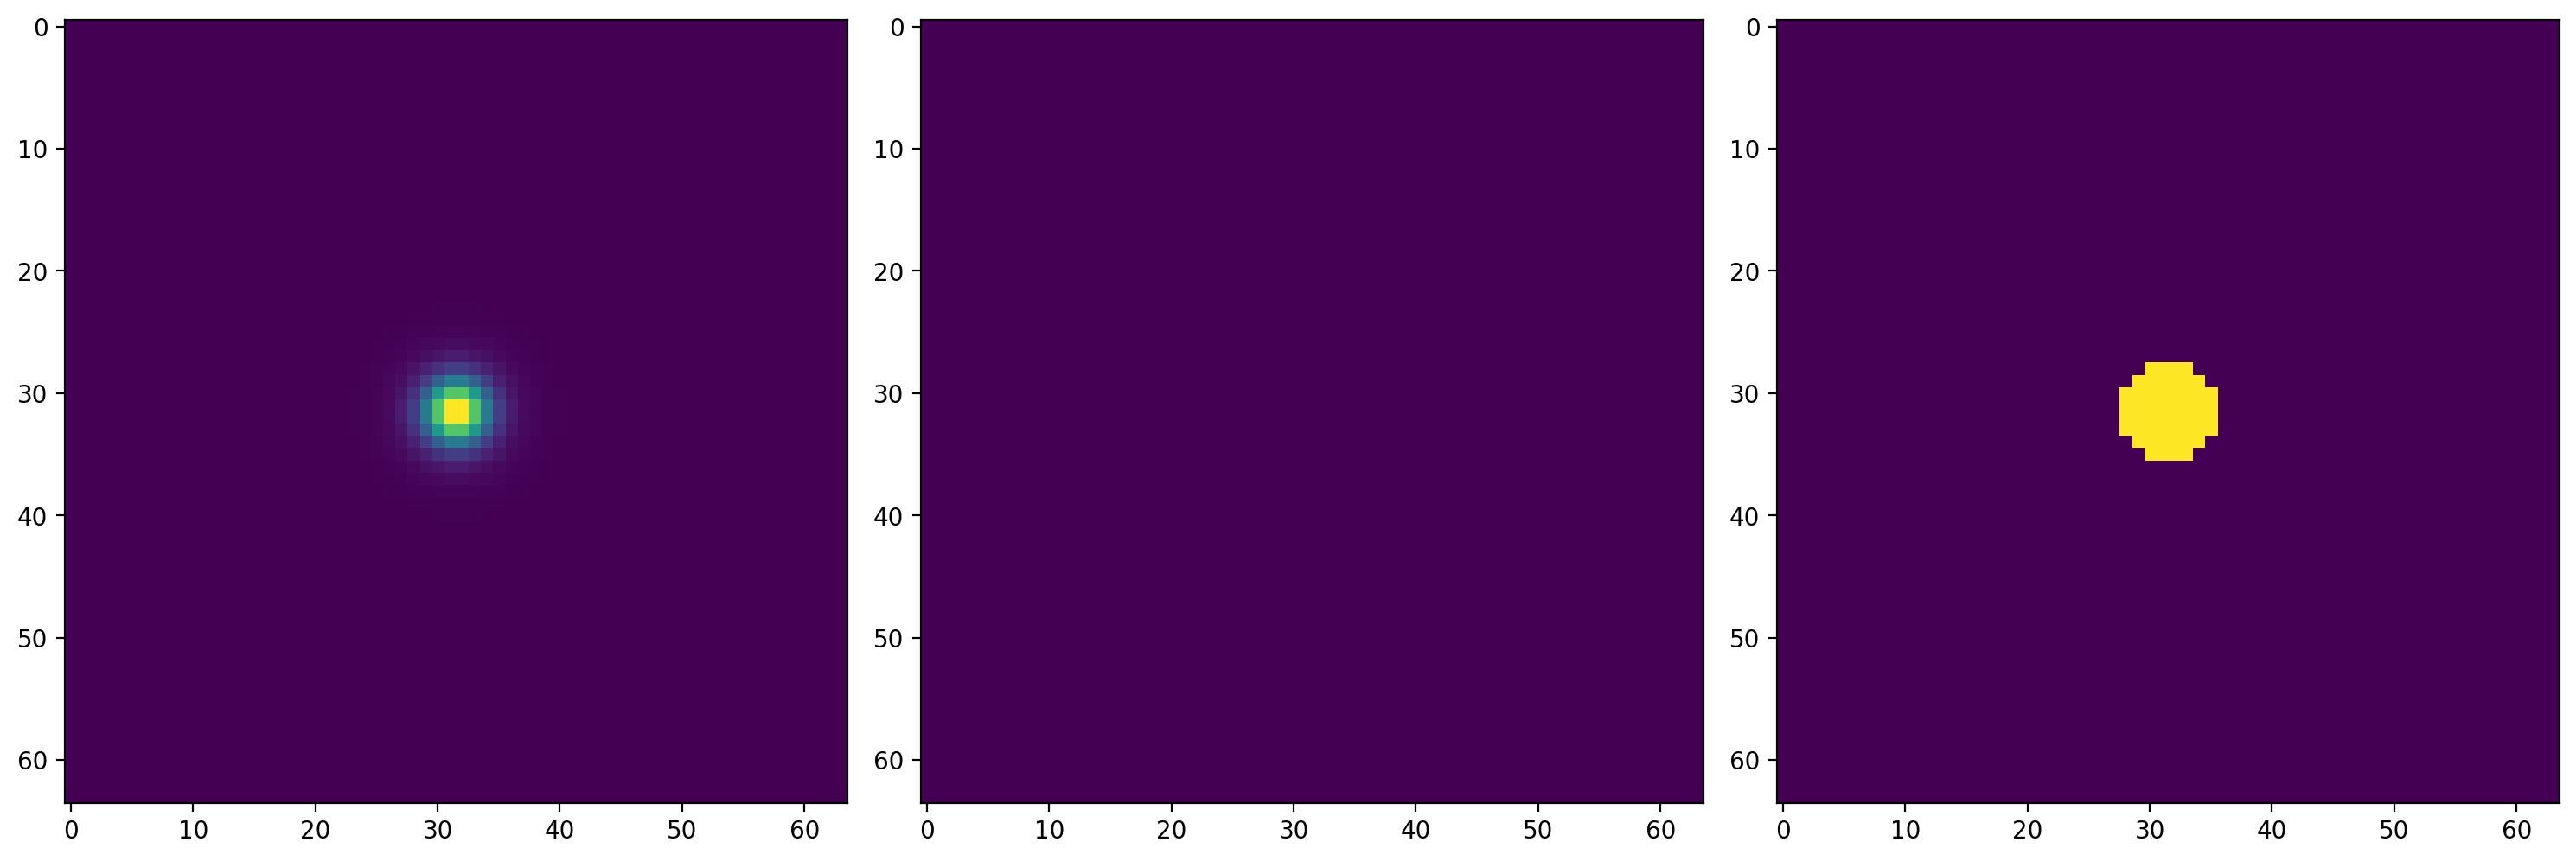

In [70]:
dt = Table.from_pandas(dcut)
survey = btk.survey.get_surveys("LSST")
filt = 'i'
nx=64
ny=64
entry = dt[7]
#entry = dt[134]
gal = make_galaxy(entry, survey, survey.get_filter(filt))
#ang = entry['position_angle_true'] -entry['morphology/positionAngle']
psf = survey.get_filter(filt).psf


#pa = np.pi*entry['position_angle_true_dc2']/180

#e1 = entry['morphology/totalEllipticity'] * np.cos(2*entry['position_angle_true'])
#e2 = entry['morphology/totalEllipticity'] * np.sin(2*entry['position_angle_true'])
#ang = e1e2_to_ephi(e1,e2)*180/np.pi

#gal = gal.rotate(galsim.Angle(ang, unit=galsim.degrees))
gal = gal.shear(e1=entry["g1"], e2=entry["g2"])

scale = survey.pixel_scale.to_value("arcsec")
image = galsim.Image(nx,ny, scale=scale)
gal_conv = galsim.Convolve(gal, psf)
im = gal_conv.drawImage(image,scale=scale)
image = galsim.Image(nx,ny, scale=scale)
gal_conv2 = galsim.Convolve(gal_conv, psf)
im2 = gal_conv2.drawImage(image,scale=scale,method='no_pixel')

imd = np.expand_dims(np.expand_dims(im2.array,0),0)
#sky_level = mean_sky_level(survey, filt).to_value('electron')
#sky_level = 0.21731390097217607
#neff = 2.266 * (0.8/0.2)**2
noise = 0.059224408**2
psfim = psf.drawImage(nx=64,ny=64)
psf_fac = np.sum(psfim.array**2)

#sig = gaussian_fwhm_to_sigma * psf.calculateFWHM()
#psf_fac = np.pi*sig**2
#psf_fac = (psf.calculateMomentRadius(scale=scale))**2*np.pi
maskf = btk.metrics.utils.get_segmentation(imd, noise, sigma_noise=5)[0][0]

maskf3 = btk.metrics.utils.get_segmentation(imd, noise*psf_fac, sigma_noise=5)[0][0]


fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(im.array)
ax[1].imshow(maskf)
ax[2].imshow(maskf3)
plt.tight_layout()

In [29]:
np.sqrt((8.8**2 + (0.2*30))*1)

9.13454979733539

In [113]:
ri = np.random.rand(6,6)

In [86]:
10**0.4*(27-entry['i_ab'])

2.4093293619063525

In [121]:
import astropy.units as u

print((entry['i_ab']*u.ABmag).to_value(u.nJy))

(30.028640637070968*u.ABmag).to_value(u.nJy)

139.20938603669262


3.5362563894919368

In [96]:
img.std()

0.1357279

In [10]:
def roman_truth_key_mapper(dataset_dict): # needs to return where the cutout image data for each cutout is stored 
    fprefix = os.path.join(*dataset_dict['file_name'].split('/')[:-1])
    ftruth = f"truth{dataset_dict['file_name'][2:].split('/')[-1].split('full')[1]}"
    fpath = os.path.join(f'/{fprefix}',ftruth).split('.npy')[0]
    fpath = fpath+'.json'
    return fpath

In [11]:
ftruth = roman_truth_key_mapper(success_ddict)
with open(ftruth, 'r') as f:
    truth_data = json.load(f)
    

fdet = '/home/shared/hsc/roman_lsst/lsst_data/truth/dc2_52.49_-39.1/det_c34_52.49_-39.1.json'
with open(fdet, 'r') as f:
    det_data = json.load(f)

In [12]:
#    u: 23.9, 26.1 mag
#    g: 25.0, 27.4 mag
#    r: 24.7, 27.5 mag
#    i: 24.0 , 26.8 mag
#    z: 23.3, 26.1 mag
#    y: 22.1, 24.9 mag

yr10mags = np.array([26.1,27.4,27.5,26.8,26.1,24.9])

yr5mags = yr10mags - 2.5*np.log10(np.sqrt(2))
yr5mags


array([25.72371251, 27.02371251, 27.12371251, 26.42371251, 25.72371251,
       24.52371251])

In [13]:
imfn = f"{lsst_dir}dc2_{tile_name}/full_c{cutout_id}_{tile_name}.npy"
image = np.load(imfn)


In [149]:
xs = []
ys= []

for i in range(len(success_ddict['annotations'])):
    xs.append(success_ddict['annotations'][i]['bbox'][0]+ success_ddict['annotations'][i]['bbox'][2]/2) 
    ys.append(success_ddict['annotations'][i]['bbox'][1]+ success_ddict['annotations'][i]['bbox'][3]/2)
    
xstcut =  [obj['cutout_x'] for obj in truth_data if obj['mag_i']<26.4]
ystcut =  [obj['cutout_y'] for obj in truth_data if obj['mag_i']<26.4]

xst =  [obj['cutout_x'] for obj in truth_data]
yst =  [obj['cutout_y'] for obj in truth_data]

xsdcut =  [obj['cutout_x'] for obj in det_data if obj['mag_i_cModel']<26.4]
ysdcut =  [obj['cutout_y'] for obj in det_data if obj['mag_i_cModel']<26.4]

(-0.5, 147.5, 147.5, -0.5)

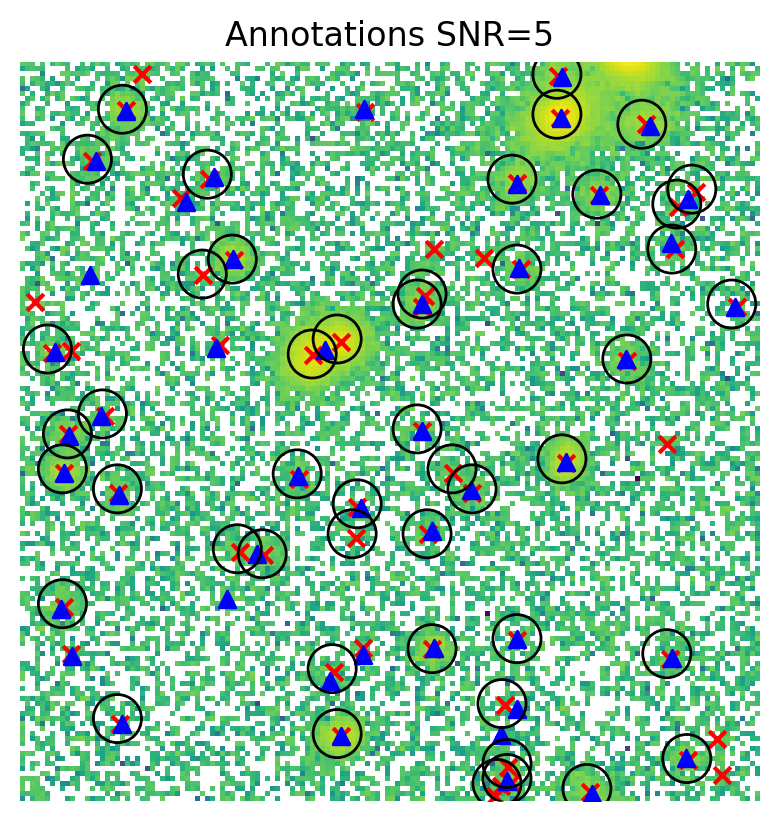

In [165]:
plt.imshow(image[3],norm=colors.LogNorm())
plt.scatter(xstcut,ystcut,marker='x',color='r')
plt.scatter(xsdcut,ysdcut,marker='^',color='b')

plt.scatter(xs,ys,marker='o',facecolors='none',edgecolors='k', s=300)

#plt.scatter(xst,yst,marker='.',color='k')

plt.title('Annotations SNR=5')
plt.axis('off')

In [14]:
xs = []
ys= []

for i in range(len(success_ddict['annotations'])):
    xs.append(success_ddict['annotations'][i]['bbox'][0]+ success_ddict['annotations'][i]['bbox'][2]/2) 
    ys.append(success_ddict['annotations'][i]['bbox'][1]+ success_ddict['annotations'][i]['bbox'][3]/2)
    
xstcut =  [obj['cutout_x'] for obj in truth_data if obj['mag_u']<yr5mags[0] or obj['mag_g']<yr5mags[1] or obj['mag_r']<yr5mags[2] or obj['mag_i']<yr5mags[3] or obj['mag_z']<yr5mags[4] or obj['mag_y']<yr5mags[5]]
ystcut =  [obj['cutout_y'] for obj in truth_data if obj['mag_u']<yr5mags[0] or obj['mag_g']<yr5mags[1] or obj['mag_r']<yr5mags[2] or obj['mag_i']<yr5mags[3] or obj['mag_z']<yr5mags[4] or obj['mag_y']<yr5mags[5]]

xst =  [obj['cutout_x'] for obj in truth_data]
yst =  [obj['cutout_y'] for obj in truth_data]

xsdcut =  [obj['cutout_x'] for obj in det_data]
ysdcut =  [obj['cutout_y'] for obj in det_data]

(-0.5, 148.5, 145.5, -0.5)

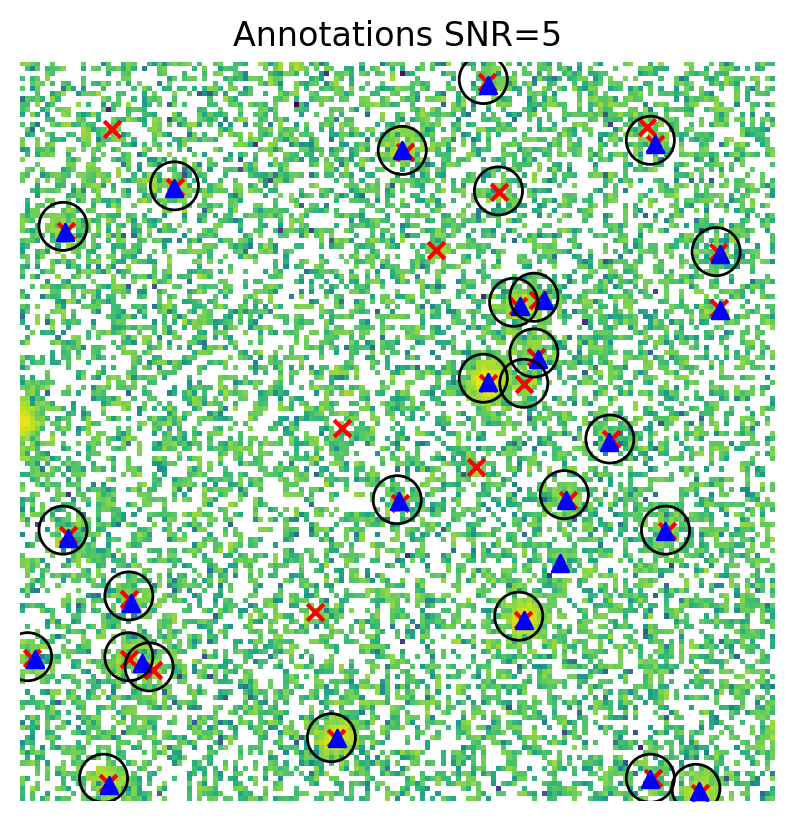

In [15]:
plt.imshow(image[3],norm=colors.LogNorm())
plt.scatter(xstcut,ystcut,marker='x',color='r')
plt.scatter(xsdcut,ysdcut,marker='^',color='b')

plt.scatter(xs,ys,marker='o',facecolors='none',edgecolors='k', s=300)

#plt.scatter(xst,yst,marker='.',color='k')

plt.title('Annotations SNR=5')
plt.axis('off')

In [87]:
oids = [a['obj_id'] for a in success_ddict['annotations']]
#oids

In [102]:
ann_ids = np.array([a['obj_id'] for a in success_ddict['annotations']])
all_truth_ids = np.array([obj['id'] for obj in truth_data])
cut_truth_ids = np.array([obj['id'] for obj in truth_data if obj['mag_u']<yr5mags[0] or obj['mag_g']<yr5mags[1] or obj['mag_r']<yr5mags[2] or obj['mag_i']<yr5mags[3] or obj['mag_z']<yr5mags[4] or obj['mag_y']<yr5mags[5]])

In [108]:
np.in1d(cut_truth_ids,ann_ids)

array([ True, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True, False,
        True,  True])

In [114]:
np.where(all_truth_ids==cut_truth_ids[1])

(array([2]),)

In [160]:
img.shape

(6, 148, 148)

In [41]:
df = pd.read_json('roman_data/truth/dc2_50.93_-42.0/dc2_50.93_-42.0_info_all.json', orient='records')

In [90]:
entry = df.iloc[2]
file = entry['file_name']
img = np.load(file)[0, :, :]
objs = pd.read_json(entry['objects_info'], orient='records')
# plt.axis('off')
# plt.scatter(dcut.new_x.values,dcut.new_y.values,s=1)

/tmp/ipykernel_1165372/1093784206.py:4: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  objs = pd.read_json(entry['objects_info'], orient='records')


In [97]:
ras = objs['ra'].values
decs = objs['dec'].values
cat = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)
wcs = WCS(entry['wcs'])
xs, ys = wcs.world_to_pixel(cat)

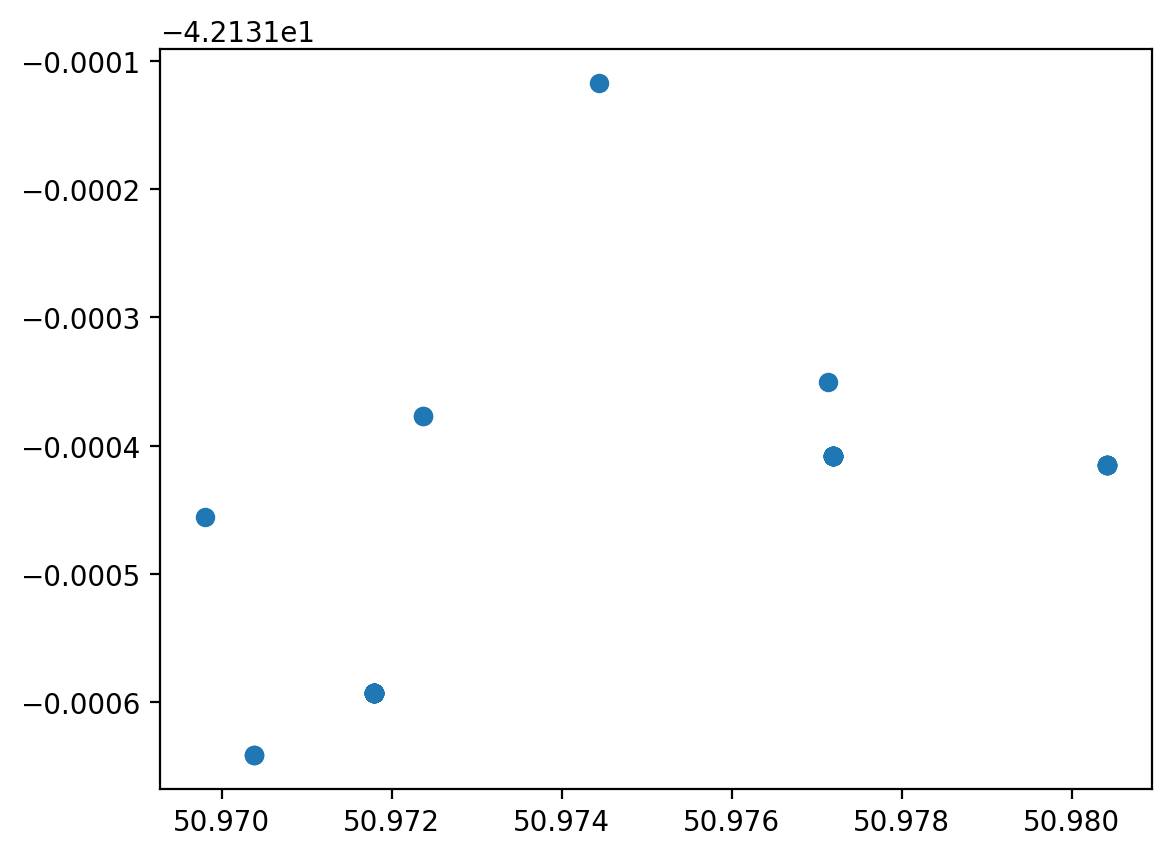

In [106]:
# plt.xlim(50.976, 51)
plt.scatter(ras,decs)

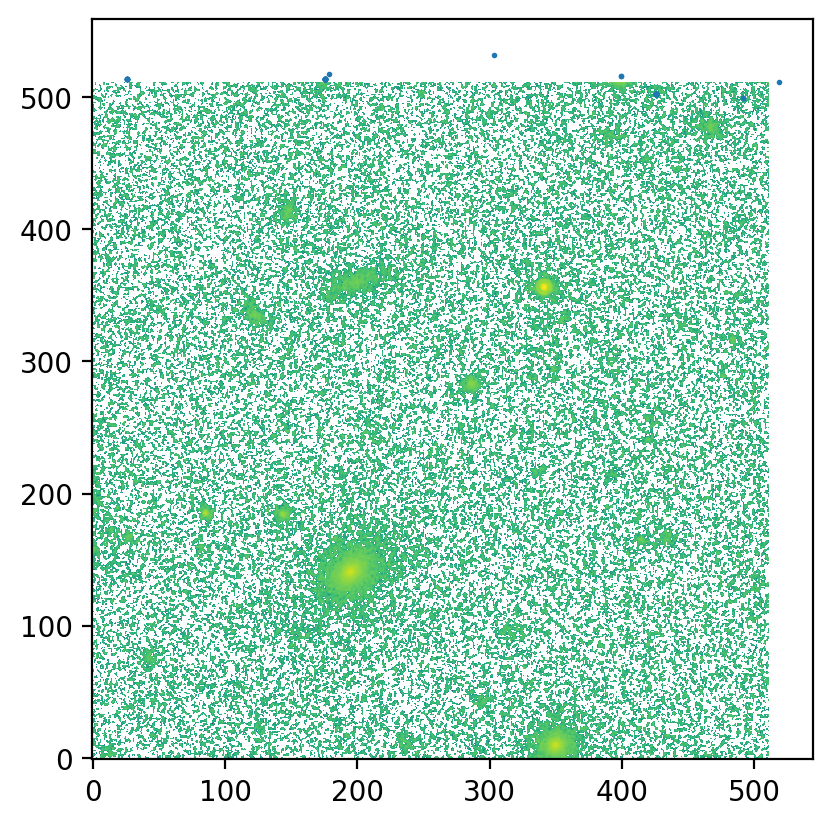

In [92]:
plt.imshow(img, norm=colors.LogNorm(), origin='lower')
# xs,ys = cutout.wcs.world_to_pixel(skycoords)
plt.scatter(xs,ys, s=1)

In [152]:
from detectron2.data import MetadataCatalog, DatasetCatalog


from matplotlib import colors

if "astro_test" in DatasetCatalog.list():
    print('removing astro_test')
    DatasetCatalog.remove("astro_test")
    MetadataCatalog.remove("astro_test")

red = np.array(colors.to_rgb('red'))*255
white = np.array(colors.to_rgb('white'))*255
blue = np.array(colors.to_rgb('blue'))*255
green = np.array(colors.to_rgb('green'))*255

#DatasetCatalog.register("astro_test", lambda: np.load(testfile))
astrotest_metadata = MetadataCatalog.get("astro_test").set(thing_classes=["galaxy", "star"]).set(thing_colors=[green, blue])
# astrotest_metadata_star = MetadataCatalog.get("astro_test").set(thing_classes=["star"]).set(thing_colors=[green])
#astrotest_metadata = register_data_set("astro_test", testfile, np.load, thing_classes=classes, thing_colors=green)

In [157]:
img.shape

(148, 148, 3)

total instances: 26


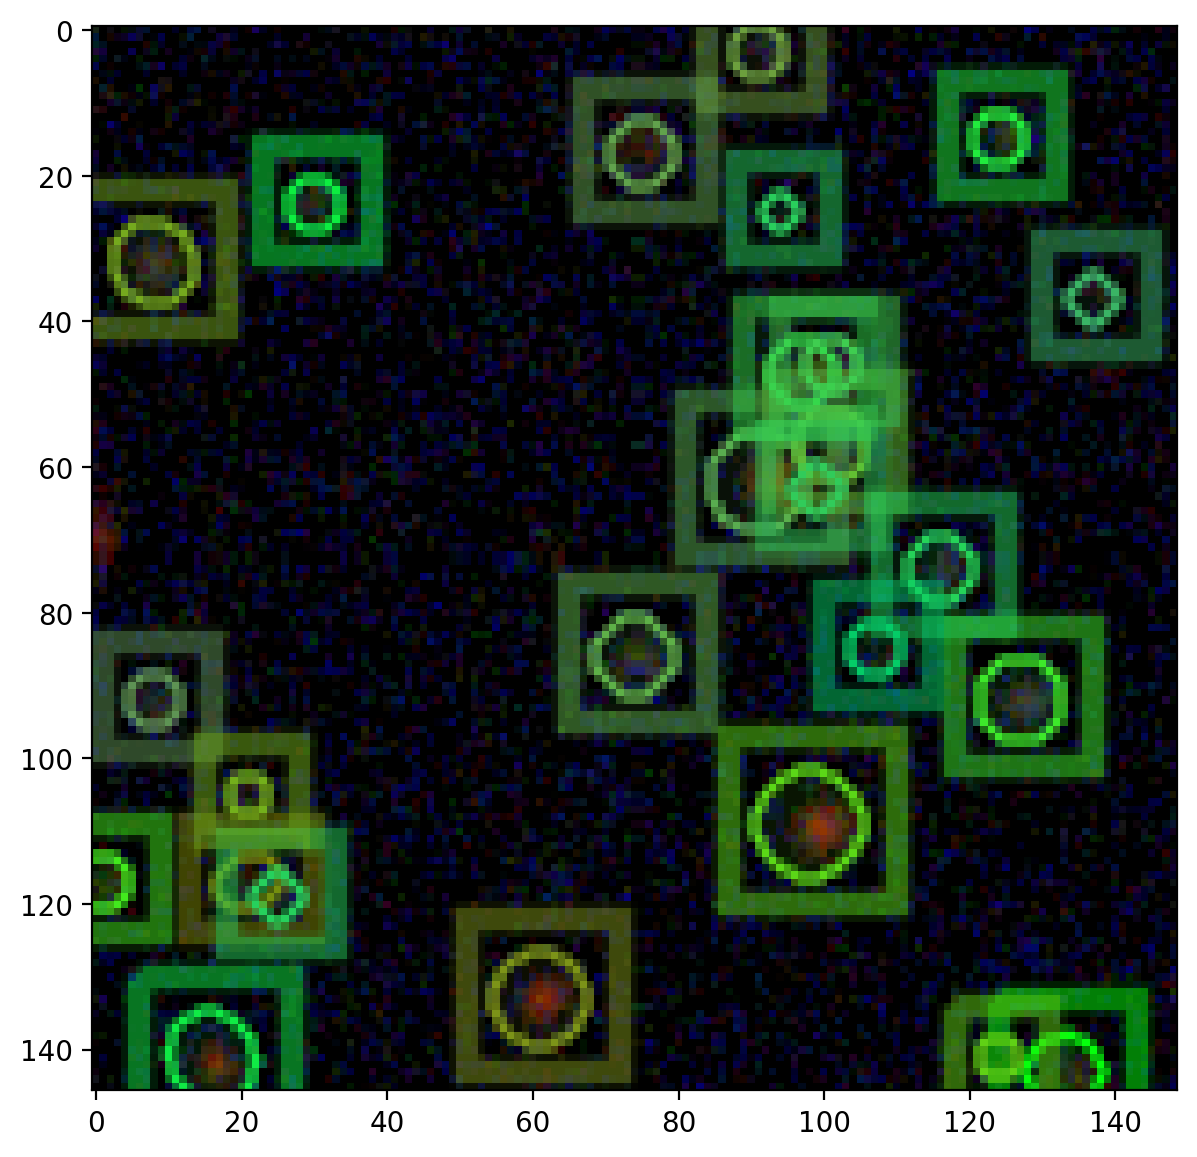

In [182]:
from deepdisc.astrodet.visualizer import ColorMode
from deepdisc.astrodet.visualizer import Visualizer
from astropy.visualization import make_lupton_rgb

plt.figure(figsize=(7,7))

b1 = image[2]
b2 = image[1]
b3 = image[0]
stretch=0.5
Q = 10
img = make_lupton_rgb(b1, b2, b3, minimum=0, stretch=stretch, Q=Q)

print("total instances:", len(success_ddict["annotations"]))
v0 = Visualizer(
    img,
    metadata=astrotest_metadata,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

groundTruth = v0.draw_dataset_dict(success_ddict, lf=False, alpha=0.1, boxf=True)

ax1 = plt.subplot(1, 1, 1)
ax1.imshow(groundTruth.get_image())
#ax1.axis("off")

#ax1.scatter(dcutr[(dcutr['new_x']>400) & (dcutr['new_y']>100)].new_x.values-400,dcutr[(dcutr['new_x']>400) & (dcutr['new_y']>100)].new_y.values-100,s=5,color='w')
#ax1.set_ylim(0,100)